In [1]:
from __future__ import print_function

"""
A reference implementation of cavity quantum electrodynamics 
configuration interactions singles.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
import scipy.linalg as la
import time
from helper_cqed_rhf import *
from helper_cis import *
from helper_cs_cqed_cis import *
from psi4.driver.procrouting.response.scf_response import tdscf_excitations

# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
#psi4.core.set_output_file('output.dat', False)

numpy_memory = 2


# Quick validation
In the next cell, we will just run a quick test of helper_cis() and helper_cqed_cis() against psi4's CIS.
Note that helper_cis is just ordinary cis but also returns the dipole expectation value of
excited CIS states, which to my knowledge is not available through psi4.
The function helper_cs_cqed_cis() is the cqed-cis method in the coherent state basis.
If the lambda_vector = 0, then all three of these methods should return the same excited-state energies.

In [2]:
mol_str = """
Mg
H 1 1.3
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options and geometry
psi4.set_options(options_dict)
mol = psi4.geometry(mol_str)

om = 0.
lam = np.array([0.,0.,0.])

n_states = 5

# run psi4 SCF
psi4_rhf_e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
# calculate the excited-state energies and save them to a dictionary called 'res'
res = tdscf_excitations(wfn, states=n_states, triplets = "NONE", tda=True)

# parse res for excitation energies
psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]

# run helper_cis()
cis_e, cis_mu, tdm = cis(mol_str, options_dict)

# run helper_cs_cqed_cis()
scf_e, cqed_cis_e, cqed_cis_c = cs_cqed_cis(lam, mol_str, options_dict, om)

# collect corresponding excitation energies for comparison
cqed_cis_to_compare = cqed_cis_e[::2]

# check to see that the cis energies match psi4s!
assert( np.isclose(psi4_rhf_e, scf_e))
assert( np.allclose(psi4_excitation_e, cis_e[:n_states]))
assert( np.allclose(psi4_excitation_e, cqed_cis_to_compare[1:n_states+1]))


Number of occupied orbitals: 6
-199.85744399880687

Start SCF iterations:

Canonical RHF One-electron energy = -285.7424508862669086
CQED-RHF One-electron energy = -285.7424508862669086
Nuclear repulsion energy = 4.8847127138769242
Dipole energy = 0.0000000000000000
SCF Iteration   1: Energy = -199.8574439988287565   dE = -1.99857E+02   dRMS = 1.39184E-08
SCF Iteration   2: Energy = -199.8574439988287565   dE =  0.00000E+00   dRMS = 3.89537E-09
Performed QED-RHF on the following molecule

Mg
H 1 1.3
symmetry c1
1 1

Total time for SCF iterations: 0.004 seconds 

QED-RHF   energy: -199.85744400 hartree
Psi4  SCF energy: -199.85744400 hartree


# MgH+ Polaritonic Potential Energy Surfaces
Create a template for the z-matrix that can be modified for different bond-lengths

In [3]:
# template for the z-matrix for MgH+
mol_tmpl = """Mg
H 1 **R**
symmetry c1
1 1"""

# options dict
options_dict = {'basis': 'sto-3g',
               'save_jk': True,
               'scf_type' : 'pk'}

psi4.set_options(options_dict)


Run a scan of the SCF, CIS, and CS-CQED-CIS energies

In [4]:
# set psi4 options
psi4.set_options(options_dict)
# array of bondlengths for MgH+
r_array = np.array([1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])

# arrays to hold psi4 cis quantities to fit the model PF Hamiltonian with
# array for transition dipole moments
tdm_array = np.zeros((3, len(r_array)))

# array for total diplole of ground and excited state 
dipole_array = np.zeros((3,2,len(r_array)))

# array for ordinary cis
cis_energy_array = np.zeros((5,len(r_array)))

# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros((5,len(r_array)))

# photon energy
om = 7.0 / 27.211

# electric field strength 
E_au = 0.005

# strength for the dipole self energy
l = E_au / np.sqrt(om/2)
lam = np.array([l,0,l])

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/sto-3g", return_wfn=True, molecule=mol)
    cis_e, cis_mu, tdm = cis(molstr, options_dict)
    
    cis_energy_array[0,ctr] = e
    cis_energy_array[1:5,ctr] = e+cis_e[0:4]
    
    scf_e, cqed_cis_e, cqed_cis_c = cs_cqed_cis(lam, molstr, options_dict, om)

    cqed_cis_energy_array[0:5,ctr] = scf_e+cqed_cis_e[0:5]
    dipole_array[:,0,ctr] = cis_mu[:,0]
    dipole_array[:,1,ctr] = cis_mu[:,1]
    tdm_array[:,ctr] = tdm
    ctr+=1
    


Number of occupied orbitals: 6
-197.49010982791265

Start SCF iterations:

Canonical RHF One-electron energy = -282.9905475064031179
CQED-RHF One-electron energy = -282.9904279065166293
Nuclear repulsion energy = 4.8847127138769242
Dipole energy = 0.0006499721191604
SCF Iteration   1: Energy = -197.4894696451452205   dE = -1.97489E+02   dRMS = 4.11791E-05
SCF Iteration   2: Energy = -197.4894699623266661   dE = -3.17181E-07   dRMS = 1.34673E-05
Performed QED-RHF on the following molecule
Mg
H 1 1.3
symmetry c1
1 1
Total time for SCF iterations: 0.002 seconds 

QED-RHF   energy: -197.48946996 hartree
Psi4  SCF energy: -197.49010983 hartree

Number of occupied orbitals: 6
-197.50813550241398

Start SCF iterations:

Canonical RHF One-electron energy = -282.3302733780435574
CQED-RHF One-electron energy = -282.3301793554605865
Nuclear repulsion energy = 4.5358046628857149
Dipole energy = 0.0007100906020338
SCF Iteration   1: Energy = -197.5074690647723514   dE = -1.97507E+02   dRMS = 4.358


Number of occupied orbitals: 6
-197.33193205786668

Start SCF iterations:

Canonical RHF One-electron energy = -278.2695152929656501
CQED-RHF One-electron energy = -278.2686340649466956
Nuclear repulsion energy = 2.4423563569384621
Dipole energy = 0.0010971104960330
SCF Iteration   1: Energy = -197.3304219841304814   dE = -1.97330E+02   dRMS = 8.84504E-05
SCF Iteration   2: Energy = -197.3304237589071022   dE = -1.77478E-06   dRMS = 3.70324E-05
SCF Iteration   3: Energy = -197.3304239518271004   dE = -1.92920E-07   dRMS = 1.42959E-05
Performed QED-RHF on the following molecule
Mg
H 1 2.6
symmetry c1
1 1
Total time for SCF iterations: 0.002 seconds 

QED-RHF   energy: -197.33042395 hartree
Psi4  SCF energy: -197.33193206 hartree

Number of occupied orbitals: 6
-197.31581853730052

Start SCF iterations:

Canonical RHF One-electron energy = -278.1248770910299299
CQED-RHF One-electron energy = -278.1238406740736764
Nuclear repulsion energy = 2.3518987140888892
Dipole energy = 0.0010978985

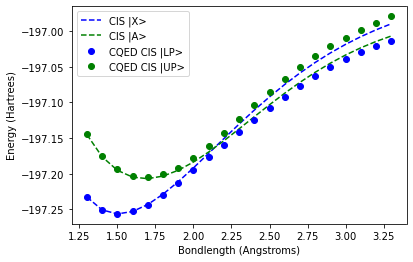

In [5]:
from matplotlib import pyplot as plt
# plot the ordinary cis energies vs the cs-cqed-cis energies

plt.plot(r_array, cis_energy_array[0,:]+om, 'b--', label="CIS |X>")
plt.plot(r_array, cis_energy_array[1,:], 'g--', label="CIS |A>")
plt.plot(r_array, cqed_cis_energy_array[1,:], 'bo', label="CQED CIS |LP>")
plt.plot(r_array, cqed_cis_energy_array[2,:], 'go', label="CQED CIS |UP>")
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

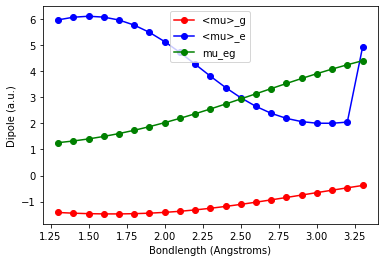

In [6]:
# plot dipole quantities
plt.plot(r_array, dipole_array[2,0,:], 'r-o', label="<mu>_g")
plt.plot(r_array, dipole_array[2,1,:], 'b-o', label="<mu>_e")
plt.plot(r_array, np.abs(tdm_array[2,:]), 'g-o', label="mu_eg")
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Dipole (a.u.)")
plt.legend()
plt.show()


#### Model system
We will consider the diatomic cation MgH+ in a cavity chosen such that it can trap a photon with a 
frequency of $\hbar \omega = 4.3$ eV. 
We will compute the singlet ground state and first singlet excited state potential energy surfaces along the
Mg-H+ stretch coordinate using time-dependent density functional theory.  We denote the ground 
state ket as $|g\rangle$ with an associated energy eigenvalue $E_g(R)$, and the excited-state $|e\rangle$
with associated energy eigenvalue $E_e(R)$ where $R$ is the bondlength.  The transition dipole
moment between $|g\rangle$ and $|e\rangle$ will also be computed using CIS, yielding $\mu_{ge}(R)$.
Both the ground and excited states have total dipole moments associated with them, $\langle \mu \rangle_g$ and
$\langle \mu \rangle_e$, respectively.

We will consider two quantum states for the photon - no photon in the cavity, denoted by $|0\rangle$ with associated energy eigenvalue $0$
and one photon in the cavity, denoted by $|1\rangle$ with associated energy eigenvalue $\frac{ \hbar \omega}{2}$.  
We will model this system with a Pauli-Fierz Hamiltonian that can be written as:

$$ \hat{H}_{PF} = E_g(R) \hat{a}_g^{\dagger} \hat{a}_g + E_e(R) \hat{a}_e^{\dagger} \hat{a}_e + 
\hbar \omega\hat{b} \hat{b}^{\dagger}  
+ \frac{1}{2} \left( \lambda \cdot \mu(R) \right)^2
- \sqrt{\frac{\omega}{2}} \left( \lambda \cdot \mu(R) \right) \left(\hat{b}^{\dagger} + \hat{b}\right)
$$
The polaritonic potential energy surfaces may be obtained by building a Hamiltonian matrix in the following basis and diagonalizing as a function of the bond length $R$: $ |\phi\rangle \in \{|g,0\rangle , |g,1\rangle , |e,0\rangle. $


This matrix as a function of the bond-length $R$ is as follows:
\begin{equation}
{\bf H}(R)
  \mbox{=} 
  \begin{array}{c|cccc}
       & |g,0\rangle & |g,1\rangle & |e,0\rangle \\
    \hline
    \langle g,0| & E_g(R) + (\lambda \cdot \langle \mu \rangle_g)^2  &     0   & 0  \\
    \langle g,1| & 0        &   E_g(R) +  \hbar \omega + \frac{1}{2}(\lambda \cdot \langle \mu \rangle_g)^2  & \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{ge} \\
    \langle e,0| & 0        &    \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{ge} & E_e(R) + \frac{1}{2}(\lambda \cdot \langle \mu \rangle_e)^2\\
  \end{array}
\end{equation}

In [7]:
from numpy import linalg as LA
from scipy.interpolate import InterpolatedUnivariateSpline

# fit splines in case you want polaritonic states at finer spacings
cis_s0_spline = InterpolatedUnivariateSpline(r_array, cis_energy_array[0,:], k=3)
cis_s1_spline = InterpolatedUnivariateSpline(r_array, cis_energy_array[1,:], k=3)

tdm_spline = InterpolatedUnivariateSpline(r_array, np.abs(tdm_array[2,:]), k=3 )

mu_g_spline = InterpolatedUnivariateSpline(r_array, dipole_array[2,0,:])
mu_e_spline = InterpolatedUnivariateSpline(r_array, dipole_array[2,1,:])


Htot = np.zeros((3,3))

''' Polaritonic Hamiltonian will have the following structure

    | E_g(r)+0.5*(l.<mu>_g)^2                   0                                         0              |
    | 0                           E_g(r) + h*om + 0.5*(l.<mu>_g)^2               E_au*mu_eg          |
    | 0                                     E_au*mu_eg                      E_e(r) + 0.5*(l.<mu>_e)^2    |
    
'''

pl_1 = np.zeros_like(r_array)
pl_2 = np.zeros_like(r_array)
pl_3 = np.zeros_like(r_array)
# build the hamiltonian matrix and diagonalize at each geometry
for i in range(0,len(r_array)):
    Htot[0,0] = cis_s0_spline(r_array[i]) + 0.5 * (l * mu_g_spline(r_array[i]))**2
    Htot[1,1] = cis_s0_spline(r_array[i]) + om + 0.5 * (l * mu_g_spline(r_array[i]))**2
    Htot[1,2] = E_au * tdm_spline(r_array[i])
    Htot[2,1] = E_au * tdm_spline(r_array[i])
    Htot[2,2] = cis_s1_spline(r_array[i]) + 0.5 * (l * mu_e_spline(r_array[i]))**2
    
    # diagonalize
    vals, vecs = LA.eig(Htot)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    # store eigenvalues
    pl_1[i] = np.real(vals[0])
    pl_2[i] = np.real(vals[1])
    pl_3[i] = np.real(vals[2])





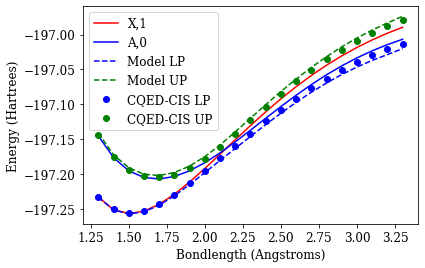

In [8]:
# now plot the ordinary cis energies vs both the model and the cs-cqed-cis energies
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

plt.plot(r_array, cis_s0_spline(r_array)+om, 'red', label='X,1')
plt.plot(r_array, cis_s1_spline(r_array), 'blue', label='A,0')
plt.plot(r_array, pl_2, 'b--', label="Model LP")
plt.plot(r_array, pl_3, 'g--', label="Model UP")
plt.plot(r_array, cqed_cis_energy_array[1,:], 'bo', label="CQED-CIS LP")
plt.plot(r_array, cqed_cis_energy_array[2,:], 'go', label="CQED-CIS UP")

plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
#plt.savefig("mghplus_stretch.eps")
plt.show()

In [ ]:
''' 
# this follows the ci-vector across the curve crossing
    # that occurs btw |X,1> and |A,0> without coupling
    if ctr>0 and np.isclose(l,0):
        ol11 = np.dot(cqed_cis_c[:,1], old_vecs[:,1])
        ol22 = np.dot(cqed_cis_c[:,2], old_vecs[:,2])
        ol12 = np.dot(cqed_cis_c[:,1], old_vecs[:,2])
        ol21 = np.dot(cqed_cis_c[:,2], old_vecs[:,1])

        print("Overlaps for r = ",r)
        print("<1|1>:",ol11)
        print("<2|2>:",ol22)
        print("<1|2>:",ol12)
        print("<2|1>:",ol21)
        if np.abs(ol12)>np.abs(ol11):
            temp_c1 = np.copy(cqed_cis_c[:,2])
            temp_c2 = np.copy(cqed_cis_c[:,1])
            temp_e1 = cqed_cis_e[2]
            temp_e2 = cqed_cis_e[1]
            
            cqed_cis_c[:,1] = np.copy(temp_c1)
            cqed_cis_c[:,2] = np.copy(temp_c2)
            cqed_cis_e[1] = temp_e1
            cqed_cis_e[2] = temp_e2
            
    old_vecs = np.copy(cqed_cis_c)
    #scf_e, cqed_cis_e, cqed_cis_c = cqed_cis(lam, molstr, options_dict, om)
    #cqed_cis_energy_array[0,ctr] = scf_e+om
'''